# Amazon Food Reviews - [Logistic Regression]

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

con = sqlite3.connect('preprocessed.sqlite')#Loading the data set which was saved after peforming preprocessing steps in k-nn 


data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con) 

In [2]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [3]:
def polarity(X):
    if X=='positive':
        return 1
    else:
        return 0
data["Score"]=data["Score"].map(polarity)
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [4]:
data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [5]:
data.sort_values('Time',inplace=True)
data.head(5)
#Splitting on time based

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


# Bag Of Words(BOW)

In [6]:
#%%pixie_debugger
#import pixiedust
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.model_selection import train_test_split


#Splitting the data in o train and test data sets
X_train, X_test, y_train, y_test=train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3,random_state=0)


count_vect = CountVectorizer() 
X_train = count_vect.fit_transform(X_train)
print(X_train.shape)
print(type(X_train))


X_test=count_vect.transform(X_test)
print(X_test.shape)
print(type(X_test))


(254919, 59640)
<class 'scipy.sparse.csr.csr_matrix'>
(109252, 59640)
<class 'scipy.sparse.csr.csr_matrix'>


In [61]:
#Normalizing the data
from sklearn import preprocessing

X_train=preprocessing.normalize(X_train)
print(X_train.shape)

X_test=preprocessing.normalize(X_test)
print(X_test.shape)


print(type(X_test.shape))
print(type(X_train.shape))

(254919, 59198)
(109252, 59198)
<class 'tuple'>
<class 'tuple'>


#  Using GridSearchCV

In [65]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
gsv = GridSearchCV(clf,param_grid,cv=10)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'C': 5, 'penalty': 'l2'}
Best Accuracy: 92.57%
Wall time: 1h 7min 28s


Wall time: 0 ns
Accuracy on test set: 91.851%
Precision on test set: 0.934
Recall on test set: 0.970
F1-Score on test set: 0.952
Non Zero weights: 59198
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



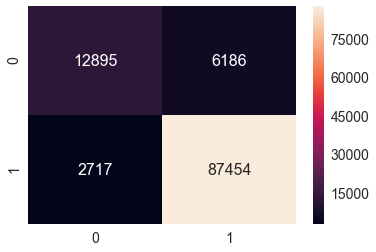

In [66]:
%time
#Metrics 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import recall_score 
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(X_train1,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Using RandomizedsearchCV for hyperparameter tuning

In [10]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
gsv = RandomizedSearchCV(clf,param_grid,cv=10)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Best HyperParameter:  {'penalty': 'l2', 'C': 10}
Best Accuracy: 92.52%


# Sparsity When L1 regularization is used for different 'C' values

In [11]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.555%
Precision on test set: 0.937
Recall on test set: 0.952
F1-Score on test set: 0.944
Non Zero weights: 34567


In [12]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 500, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.732%
Precision on test set: 0.938
Recall on test set: 0.953
F1-Score on test set: 0.945
Non Zero weights: 31933


In [13]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 50, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.690%
Precision on test set: 0.942
Recall on test set: 0.960
F1-Score on test set: 0.951
Non Zero weights: 20973


In [14]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.287%
Precision on test set: 0.938
Recall on test set: 0.973
F1-Score on test set: 0.955
Non Zero weights: 2266


In [15]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 86.791%
Precision on test set: 0.869
Recall on test set: 0.993
F1-Score on test set: 0.927
Non Zero weights: 80


We can clearly see that how sparsity decreases when different set of C values are introduced(Lambda increases)

# FEATURE IMPORTANCE

In [50]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vect,clf)

	-7.6165	disappoint     		6.6685	great          
	-5.2406	return         		5.8905	best           
	-3.6589	money          		5.7967	delici         
	-3.6529	bad            		4.8976	love           
	-3.2158	wast           		4.8698	perfect        
	-2.5666	horribl        		3.6992	excel          
	-2.4234	thought        		3.4240	favorit        
	-2.2121	terribl        		3.3942	nice           
	-2.1939	aw             		2.9176	good           
	-2.1670	away           		2.4950	enjoy          
	-1.8803	worst          		2.0913	easi           
	-1.7466	didnt          		1.9753	keep           
	-1.6779	would          		1.9638	find           
	-1.6618	tast           		1.9276	wonder         
	-1.4592	review         		1.8442	tasti          
	-1.4542	receiv         		1.4111	littl          
	-1.4035	product        		1.3498	thank          
	-1.3310	box            		1.3374	recommend      
	-1.1276	smell          		1.3086	well           
	-1.1031	even           		1.2882	happi          


# tf-idf

In [51]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer() 
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (254919, 59198)
Test Data Size:  (109252, 59198)
Wall time: 16.6 s


In [52]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
gsv = GridSearchCV(clf,param_grid,cv=10)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.f%%"%(gsv.best_score_*100))


Best HyperParameter:  {'C': 5, 'penalty': 'l2'}
Best Accuracy: 93%
Wall time: 52min 26s


Accuracy on test set: 91.853%
Precision on test set: 0.934
Recall on test set: 0.970
F1-Score on test set: 0.952
Non Zero weights: 59198
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



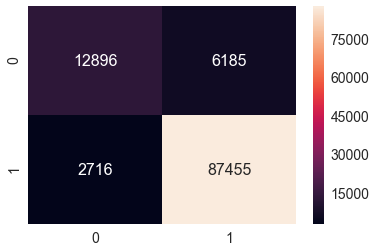

In [53]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')